In [1]:
# fmt: off
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "07_training/07d_distribute.ipynb"
_nb_title = "Distributed Training"

_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))
# fmt: on

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Distributed+Training&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F07_training%2F07d_distribute.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/07_training/07d_distribute.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/07_training/07d_distribute.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/07_training/07d_distribute.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# 分散学習

このノートブックでは、GPUやTPUを用いてモデルをトレーニングする方法を示します。<br>
以下のコードは様々なアクセレレーターに合わせて自動的にストラテジーを選択するように動作します。

## 実行環境
このノートブックは、TPU上でもGPU上でも実行可能です。

Vertex AI WorkbenchやColabでGPUやTPUを使用する方法については[実行環境のセットアップ
](https://github.com/takumiohym/practical-ml-vision-book-ja/tree/main/environment_setup)を参照してください。


Colabを利用している場合、以下のセルを実行してアカウントの認証を行ってください。

In [ ]:
# If you are running on Colaboratory, you must authenticate
# for Colab to have write access to the bucket.
import os

IS_COLAB_BACKEND = 'COLAB_RELEASE_TAG' in os.environ  # this is always set on Colab
if IS_COLAB_BACKEND:
    from google.colab import auth
    auth.authenticate_user()

## Google Cloud Storageバケットの作成
最終的なモデルの保存先として、Google Cloud Storageを利用します。<br>
また、TPUを利用する場合は、学習中に作成するCheckpointデータもGCSへ保存します。

以下のBUCKETの値を使用可能なGSCバケット名に変更して進めてください。<br>
使用できるバケットがない場合は、以下の二行目と三行目のコマンドをコメントアウトし、PROJECTにGoogle Cloudプロジェク名を指定し、gsutil mbコマンドを実行して作成してください。

In [ ]:
BUCKET='BUCKET_NAME' # Specify your GCS bucket name
# PROJECT = 'PROJECT_NAME'
# !gsutil mb -l us-central1 -p {PROJECT} gs://{BUCKET} 

Colabから実行する際は、以下を実行してColabのTPU用サービスアカウントからのアクセスを許可してください。
（ColabのTPUのサービスアカウントには以下の値が使用されていますが、もし後ほどアクセスエラーが出る場合は、以下のCOLAB_TPU_SERVICE_ACCOUNTをエラーメッセージに出力される`service-@cloud-tpu.iam.gserviceaccount.com`に置き換えて次のセルを再実行してください。

In [ ]:
if IS_COLAB_BACKEND:
    COLAB_TPU_SERVICE_ACCOUNT = "service-495559152420@cloud-tpu.iam.gserviceaccount.com"
    !gsutil iam ch serviceAccount:{COLAB_TPU_SERVICE_ACCOUNT}:objectAdmin gs://{BUCKET}
    !gsutil iam ch serviceAccount:{COLAB_TPU_SERVICE_ACCOUNT}:admin gs://{BUCKET}

## 各種パラメータの設定

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os, shutil
from tensorflow.data import AUTOTUNE

#PATTERN_SUFFIX, NUM_EPOCHS = '-0000[01]-*', 3 # small
PATTERN_SUFFIX, NUM_EPOCHS = '-*', 20 # full

IMG_HEIGHT = 448 # note *twice* what we used to have
IMG_WIDTH = 448
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()

CHECKPOINT_DIR='./chkpts'
OUTDIR = './export' 

## ストラテジーを作成する

分散ストラテジーと、各種パラメータの設定を行います。

特に、TPUの場合には`OUTDIR`と`CHECKPOINT_DIR`をGCSに置き換えていることに注目してください。

In [3]:
def setup_local_trainer():
    shutil.rmtree(CHECKPOINT_DIR, ignore_errors=True)
    os.mkdir(CHECKPOINT_DIR)
    shutil.rmtree(OUTDIR, ignore_errors=True)
    os.mkdir(OUTDIR)
    # Load compressed models from tensorflow_hub
    os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
    
def create_strategy():
    global OUTDIR, CHECKPOINT_DIR
    try: # detect TPUs
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        print("All devices: ", tf.config.list_logical_devices('TPU'))
        OUTDIR = f'gs://{BUCKET}/export'
        CHECKPOINT_DIR = f'gs://{BUCKET}/chkpts'
        os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'UNCOMPRESSED'
        return tf.distribute.TPUStrategy(tpu)
    except ValueError: # detect GPUs or multi-GPU machines
        setup_local_trainer()
        if tf.test.is_built_with_cuda():
            if len(tf.config.experimental.list_physical_devices("GPU")) > 1:
                print("Using TFCONFIG=", os.environ["TF_CONFIG"])
                return tf.distribute.MultiWorkerMirroredStrategy()
            else:
                print('Using {} GPUs'.format(len(tf.config.experimental.list_physical_devices("GPU"))))
                return tf.distribute.MirroredStrategy()
        else:
            return tf.distribute.OneDeviceStrategy('/cpu:0')

strategy = create_strategy()

2022-12-04 17:40:08.185846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-04 17:40:08.185898: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-04 17:40:08.185923: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tpu-direct): /proc/driver/nvidia/version does not exist


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


2022-12-04 17:40:08.384281: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 17:40:08.399529: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.112.92.178:8470}
2022-12-04 17:40:08.399577: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:55885}
2022-12-04 17:40:08.416879: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.112.92.178:8470}
2022-12-04 17:40:08.416929: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:55885}
2022-1

INFO:tensorflow:Initializing the TPU system: tpu-direct


INFO:tensorflow:Initializing the TPU system: tpu-direct


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## トレーニングコード  

以前のノートブックで使用したものと同様です。

In [ ]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])
    
class _Preprocessor:    
    def __init__(self):
        # nothing to initialize
        pass
    
    def read_from_tfr(self, proto):
        feature_description = {
            'image': tf.io.VarLenFeature(tf.float32),
            'shape': tf.io.VarLenFeature(tf.int64),
            'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }
        rec = tf.io.parse_single_example(
            proto, feature_description
        )
        shape = tf.sparse.to_dense(rec['shape'])
        img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
        label_int = rec['label_int']
        return img, label_int
    
    def read_from_jpegfile(self, filename):
        # same code as in 05_create_dataset/jpeg_to_tfrecord.py
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
      
    def preprocess(self, img):
        return tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)

# most efficient way to read the data
# as determined in 07a_ingest.ipynb
# splits the files into two halves and interleaves datasets
def create_preproc_dataset(pattern):
    """
    Does interleaving, parallel calls, prefetch, batching
    Caching is not a good idea on large datasets.
    """
    preproc = _Preprocessor()
    files = [filename for filename 
             in tf.random.shuffle(tf.io.gfile.glob(pattern))]
    if len(files) > 1:
        print("Interleaving the reading of {} files.".format(len(files)))
        def _create_half_ds(x):
            if x == 0:
                half = files[:(len(files)//2)]
            else:
                half = files[(len(files)//2):]
            return tf.data.TFRecordDataset(half,
                                          compression_type='GZIP')
        trainds = tf.data.Dataset.range(2).interleave(
            _create_half_ds, num_parallel_calls=AUTOTUNE)
    else:
        trainds = tf.data.TFRecordDataset(files,
                                         compression_type='GZIP')
    def _preproc_img_label(img, label):
        return (preproc.preprocess(img), label)
    
    trainds = (trainds
               .map(preproc.read_from_tfr, num_parallel_calls=AUTOTUNE)
               .map(_preproc_img_label, num_parallel_calls=AUTOTUNE)
               .shuffle(200)
               .prefetch(AUTOTUNE)
              )
    return trainds

def create_preproc_image(filename):
    preproc = _Preprocessor()
    img = preproc.read_from_jpegfile(filename)
    return preproc.preprocess(img)

class RandomColorDistortion(tf.keras.layers.Layer):
    def __init__(self, contrast_range=[0.5, 1.5], 
                 brightness_delta=[-0.2, 0.2], **kwargs):
        super(RandomColorDistortion, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta
    
    def call(self, images, training=None):
        if not training:
            return images
        
        contrast = np.random.uniform(
            self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1])
        
        images = tf.image.adjust_contrast(images, contrast)
        images = tf.image.adjust_brightness(images, brightness)
        images = tf.clip_by_value(images, 0, 1)
        return images

In [ ]:
def create_model(l1, l2, num_hidden):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
        
    layers = [
      tf.keras.layers.RandomCrop(
          height=IMG_HEIGHT//2, width=IMG_WIDTH//2,
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          name='random/center_crop'
      ),
      tf.keras.layers.RandomFlip(
          mode='horizontal',
          name='random_lr_flip/none'
      ),
      RandomColorDistortion(name='random_contrast_brightness/none'),
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    ]

    # checkpoint and early stopping callbacks
    model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_DIR,
        monitor='val_accuracy', mode='max',
        save_best_only=True)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', mode='max',
        patience=2)
    
    # create model
    return tf.keras.Sequential(layers, name='flower_classification')

def train_and_evaluate(strategy,
                       batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    
    train_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX
    ).batch(batch_size)
    eval_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book/flowers_tfr/valid' + PATTERN_SUFFIX
    ).batch(batch_size)

    # early stopping callbacks
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', mode='max',
        patience=2)
    
    # model training
    with strategy.scope():
        model = create_model(l1, l2, num_hidden)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(
                      from_logits=False),
                  metrics=['accuracy']
                 )
    print(model.summary())
    history = model.fit(train_dataset, 
                        validation_data=eval_dataset,
                        epochs=NUM_EPOCHS,
                        callbacks=[early_stopping_cb]
                       )
    training_plot(['loss', 'accuracy'], history)
    return model

Interleaving the reading of 16 files.
Interleaving the reading of 2 files.
Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random/center_crop (RandomC  (None, 224, 224, 3)      0         
 rop)                                                            
                                                                 
 random_contrast_brightness/  (None, 224, 224, 3)      0         
 none (RandomColorDistortion                                     
 )                                                               
                                                                 
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                    

2022-07-16 21:30:06.818705: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 11706, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1658007006.815223849","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 11706, Output num: 1","grpc_status":3}


Epoch 2/20
92/92 [==============================] - 16s 162ms/step - loss: 0.4869 - accuracy: 0.8241 - val_loss: 0.4601 - val_accuracy: 0.8394
Epoch 3/20
92/92 [==============================] - 16s 162ms/step - loss: 0.4059 - accuracy: 0.8551 - val_loss: 0.4369 - val_accuracy: 0.8290
Epoch 4/20
92/92 [==============================] - 16s 163ms/step - loss: 0.3795 - accuracy: 0.8657 - val_loss: 0.4175 - val_accuracy: 0.8368


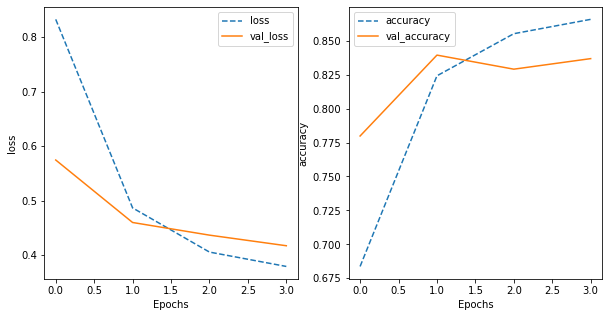

In [ ]:
model = train_and_evaluate(strategy)

In [ ]:
@tf.function(input_signature=[tf.TensorSpec([None,], dtype=tf.string)])
def predict_flower_type(filenames):
    input_images = tf.map_fn(
        create_preproc_image,
        filenames,
        fn_output_signature=tf.float32
    )
    batch_pred = model(input_images) # same as model.predict()
    top_prob = tf.math.reduce_max(batch_pred, axis=[1])
    pred_label_index = tf.math.argmax(batch_pred, axis=1)
    pred_label = tf.gather(tf.convert_to_tensor(CLASS_NAMES), pred_label_index)
    return {
        'probability': top_prob,
        'flower_type_int': pred_label_index,
        'flower_type_str': pred_label
    }

model.save(os.path.join(OUTDIR, 'flowers_model'),
          signatures={
              'serving_default': predict_flower_type
          })

## 推論

In [ ]:
serving_fn = tf.keras.models.load_model(
    os.path.join(OUTDIR, 'flowers_model')
).signatures['serving_default']
filenames = [
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/9158041313_7a6a102f7a_n.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/9299302012_958c70564c_n.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8733586143_3139db6e9e_n.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8713397358_0505cc0176_n.jpg'
]
pred = serving_fn(tf.convert_to_tensor(filenames))
print(pred)
print('******')
print(pred['flower_type_str'].numpy())

In [ ]:
f, ax = plt.subplots(1, 6, figsize=(15,15))
for idx, (filename, prob, pred_label) in enumerate(
        zip(filenames, pred['probability'].numpy(), pred['flower_type_str'].numpy())):
    
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    ax[idx].imshow((img.numpy()));
    
    ax[idx].set_title('{} ({:.2f})'.format(pred_label, prob))    

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.